In [1]:
from pathlib import Path
import numpy as np
import logging

import pyvista as pv
pv.set_jupyter_backend("pythreejs")

from project_heart.enums import *
from project_heart.lv import LV

In [2]:
filepath = Path("C:/Users/igorp/Downloads/0.3_80.00_50.00_LVIDEAL_HEX20.xplt")
# filepath = Path("C:/Users/igornobrega/Downloads/0.3_80.00_50.00_LVIDEAL_HEX20.xplt")

# Load File

In [3]:
lv = LV.from_file(filepath, log_level=logging.DEBUG)
lv.identify_regions(LV_GEO_TYPES.IDEAL,
    apex_base_args={"ab_ql":0.03, "ab_qh":0.90},
    endo_epi_args={"threshold":85,})
lv.plot("mesh", 
        scalars=LV_MESH_DATA.SURFS,
        container="points",
        show_edges=True,
        categorical=True,
        split_sharp_edges=True,
        smooth_shading=False,
        pretty=False,
        vnodes=[
            (LV_VIRTUAL_NODES.BASE, "red"),
            (LV_VIRTUAL_NODES.APEX, "red")
            ],
        )

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(position=(50000.000000…

# Compute Metric

Using some subset for numerical validation

Expected:

Epi: 95
Endo: 85
Mean: 90

We have two approaches: using the extreme values (maximum and minimum) for each nodeset, or estimate the apex and base 

INFO:LV.BaseMetricsComputations:State key added:'longitudinal_distance_1'
INFO:LV.BaseMetricsComputations:State key added:'longitudinal_distance_2'


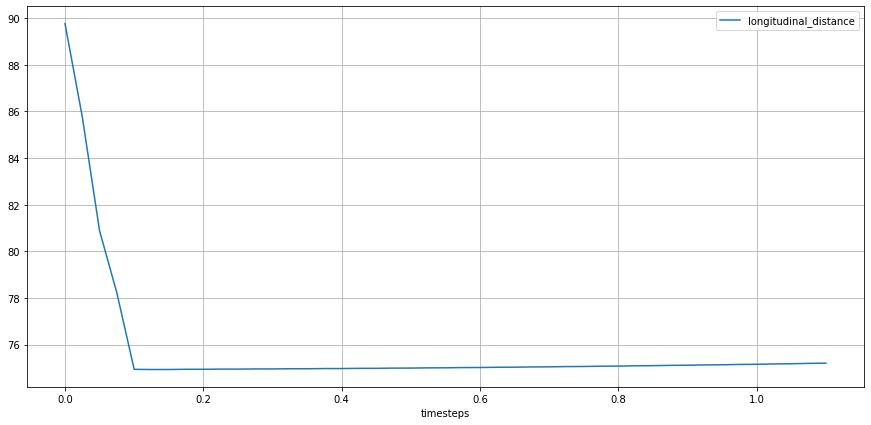

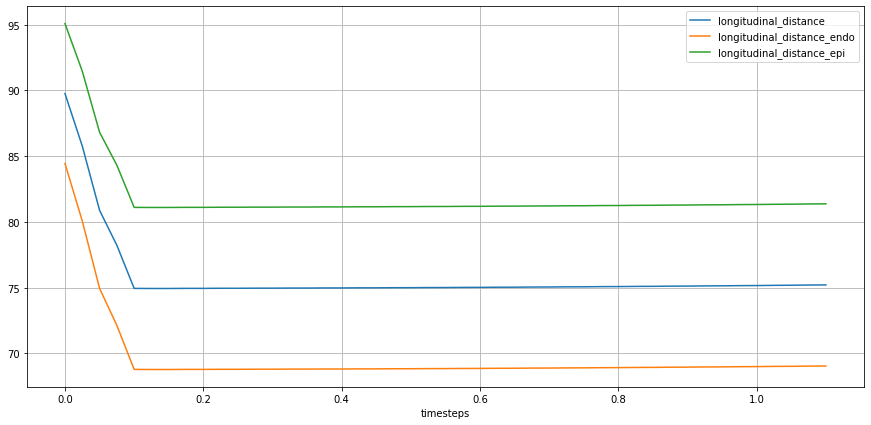

In [4]:
lv.longitudinal_distances(
    recompute=True,
    nodesets = {lv.REGIONS.ENDO, lv.REGIONS.EPI},
    approach="extremes",
)
lv.plot_metric(lv.STATES.LONG_DISTS, kind="line", search_suffix={lv.REGIONS.ENDO, lv.REGIONS.EPI})

INFO:LV.BaseMetricsComputations:State key added:'longitudinal_distance_1'
INFO:LV.BaseMetricsComputations:State key added:'longitudinal_distance_2'


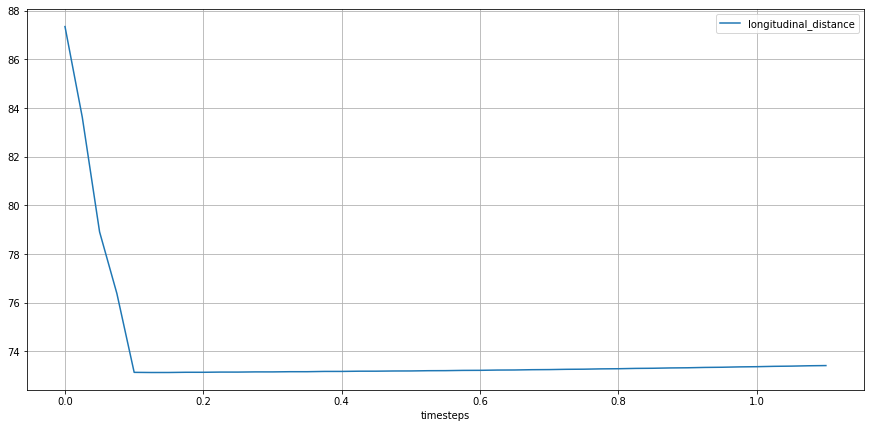

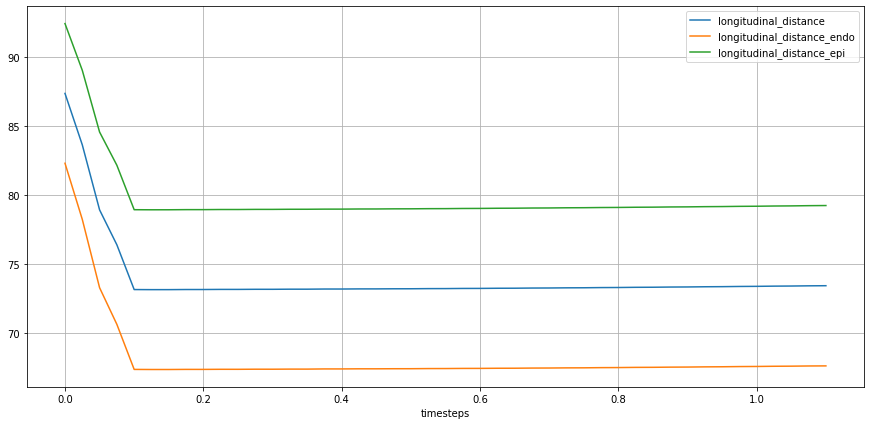

In [5]:
lv.longitudinal_distances(
    recompute=True,
    nodesets = {lv.REGIONS.ENDO_EXCLUDE_BASE, lv.REGIONS.EPI_EXCLUDE_BASE},
    approach="estimate_apex_base",
    qh=0.97,
    ql=0.01,
    n=1
)
lv.plot_metric(lv.STATES.LONG_DISTS, kind="line", search_suffix={lv.REGIONS.ENDO, lv.REGIONS.EPI})

In [6]:
import plotly.graph_objects as go
import pandas as pd

lv.compute_base_apex_ref_over_timesteps(
    nodeset=lv.REGIONS.EPI_EXCLUDE_BASE,
    ql=0.001,
    qh=0.999,
    n=3
    )

apex = lv.states.get(lv.STATES.APEX_REF)
base = lv.states.get(lv.STATES.BASE_REF)


fig = go.Figure(data=[
    go.Scatter3d(
        x=apex[:,0], 
        y=apex[:,1],
        z=apex[:,2],
        name="apex",
        marker=dict(
            size=4,
            color=lv.timesteps(),
            colorscale='Viridis',
        ),
        line=dict(
            color='darkblue',
            width=2
        )
    ),
    go.Scatter3d(
        x=base[:,0], 
        y=base[:,1],
        z=base[:,2],
        name="base",
        marker=dict(
            size=4,
            color=lv.timesteps(),
            colorscale='hot',
        ),
        line=dict(
            color='darkblue',
            width=2
        )
    ),
    ]
) 
fig.show()